## Preliminares y funciones

In [1]:
import numpy as np
import seaborn, os
from matplotlib import pyplot as plt
#import matplotlib.gridspec as gridspec
#import scipy.stats as stats

In [2]:
%run ../medidas_biodiversidad.py

In [3]:
np.set_printoptions(precision=4, suppress=True)

In [93]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
seaborn.set_palette("deep", color_codes=True)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['figure.figsize'] = (7.5, 6)
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

In [60]:
def leer_datos(het, exp = '1b'):
    directorio = "../datos/exp{}".format(exp)
    files = os.listdir(directorio)
    files.sort()
    files = list(filter(lambda x: x[7] == het, files))
    
    datos = [np.load(directorio + '/' + file) for file in files]
    comunidad = [file[10:13] for file in files]
    
    return datos, comunidad

In [6]:
def calcular_promedio(riquezas):
    """Recibe datos de riqueza.
    """
    promedios = np.zeros(10)
    std = np.zeros(10)
    median = np.zeros(10)
    for i in range(10):
        promedios[i] = np.mean(riquezas[:, i])
        std[i] = np.std(riquezas[:, i])
        median[i] = np.median(riquezas[:, i])
    return promedios, std, median

In [14]:
def ajustar_polinomio(riquezas, grado):
    x = np.array(range(10)) / 10

    res = np.polyfit(x, riquezas, grado)
    p = np.poly1d(res)
    r2 = 1 - ((np.sum((p(x) - riquezas)**2)) /
             (np.sum((riquezas - np.mean(riquezas))**2)))
    
    r2_adj = r2 - (1 - r2) * (grado/(10-grado-1))
    
    return res, p, r2_adj

## Leer datos, calcular riqueza

In [8]:
datos = np.zeros((5, 100, 10, 6, 10, 10, 10)) # het, comunidad, intensificación, tiempo, x, y, especies
for het in range(5):
    datos[het] = leer_datos(str(het))[0]

In [9]:
riqueza_total = np.zeros((5, 100, 10)) # het, comunidad, intensificación

for het in range(5):
    for comunidad in range(len(datos[het])):
        for intensificacion in range(len(datos[het, comunidad])):
            riqueza_total[het, comunidad, intensificacion] = riqueza_paisaje(
                                                    datos[het, comunidad, intensificacion, ...],
                                                    t=-1, biomasa_min = 30)[1]

¿Cuántas comunidades no tuvieron cambios en el nivel de heterogeneidad intermedio (het=2)? Este es el criterio para distinguir si la dinámica de migración y población están acopladas. El resto del análisis se hace sólo con estas comunidades, que son 80.

In [10]:
# contar cuántas comunidades no tuvieron cambios en niveles de intensificación
count = 0
con_cambios = []
for het in [2]:
    for c in range(100):
        if riqueza_total[het][c, 0] != riqueza_total[het][c, 9]:
            count += 1
            con_cambios.append(c)
100-count

21

In [32]:
np.save('./con_cambios', con_cambios)
con_cambios = np.load('con_cambios.npy')

In [15]:
riqueza_total_mean = np.zeros((5, 10)) # het, intensificación

for het in range(5):
    riqueza_total_mean[het] = calcular_promedio(riqueza_total[het, con_cambios, :])[0]

## Figure 3

In [33]:
def fig3():
    res = [None] * 5
    p = [None] * 5
    r2_adj = [None] * 5
    label = [None] * 5
    
    for het in range(5):
        res[het], p[het], r2_adj[het] = ajustar_polinomio(riqueza_total_mean[het], 2)
        label[het] = '$y = {:+.1f} x^2 {:+.1f} x {:+.1f}$ \n $R^2_{{adj}}={:.4f}$ '.format(
                 float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2_adj[het]))
        
        if ajustar_polinomio(riqueza_total_mean[het], 1)[2] > r2_adj[het]:
            res[het], p[het], r2_adj[het] = ajustar_polinomio(riqueza_total_mean[het], 1)
            
            label[het] = '$y = {:+.1f} x {:+.1f}$ \n $R^2_{{adj}}={:.4f}$ '.format(
                 float(p[het][1]), float(p[het][0]), float(r2_adj[het]))
    
    x = np.linspace(0, .9, 100)
    xdata = np.array(range(10)) / 10
    xlabels = np.array(range(10)) / 10 

    puntos = ["o", "p", "d", "v", "s"]
    colores = ['#E6852B', '#23B823', '#9BA7F5','#697CF5','#2F3E9D']
    
    fig = plt.figure()

    for het in range(5):
        plt.plot(x, p[het](x), lw = 4, color= colores[het], 
                 label='{} \n {}'.format(het, label[het])) #fit
        plt.plot(xdata, riqueza_total_mean[het], 'o', color= colores[het]) #data points
        
    plt.ylim(-0.05, 6.5)
    plt.xlim(-0.01, .91)
    plt.xticks(xdata, xlabels)
    plt.xlabel("fraction of low quality patches")
    plt.ylabel('Mean richness')
    plt.title('Richness decline in 10%-habitat landscapes')
    plt.legend(loc='upper left', title="heterogeneity", bbox_to_anchor=(1, 1), frameon=1)
    plt.tight_layout()

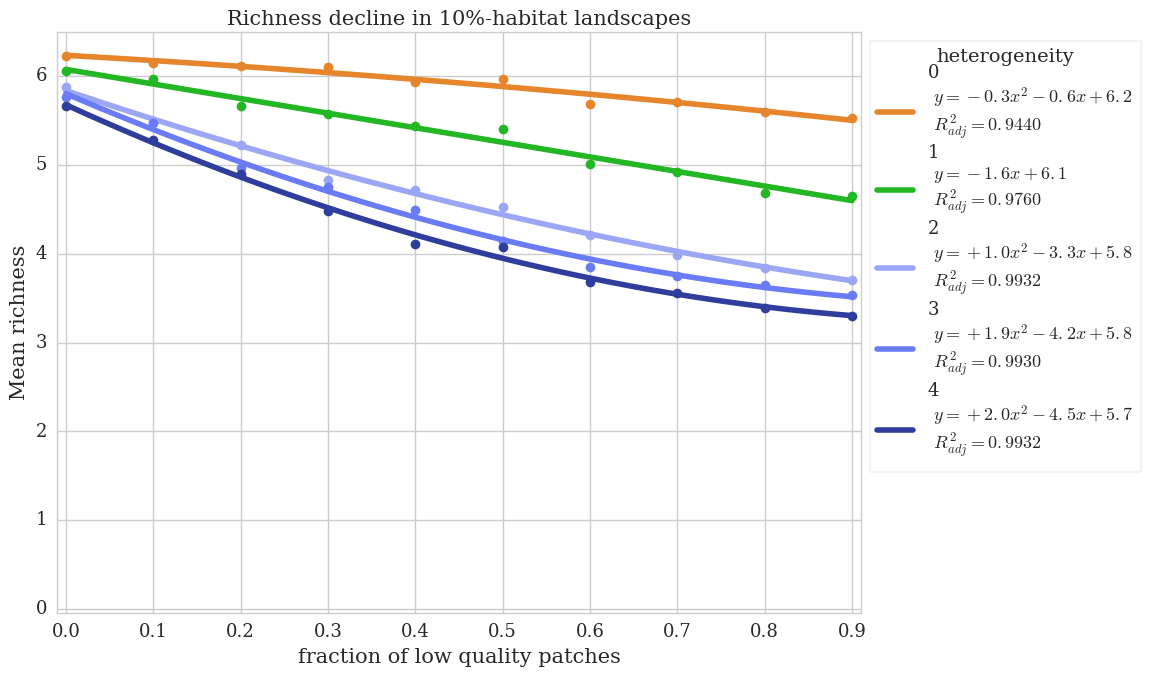

In [34]:
fig3()

## Figure 4c: Umbral

In [81]:
def fig4c():
    het = 2
    umbrales = [5, 15, 30, 100]
    
    res = [None] * 5
    p = [None] * 5
    r2_adj = [None] * 5
    label = [None] * 5
    
    riqueza_total = np.zeros((5, 100, 10)) # threshold, comunidad, intensificación
    riqueza_total_mean = np.zeros((5, 10)) # threshold, intensificación

    for i, umbral in enumerate(umbrales):
        
        for comunidad in range(len(datos[het])):
            for intensificacion in range(len(datos[het, comunidad])):
                riqueza_total[i, comunidad, intensificacion] = riqueza_paisaje(
                                                                datos[het, comunidad, intensificacion, ...],
                                                                t=-1, biomasa_min = umbral)[1]
        
        riqueza_total_mean[i] = calcular_promedio(riqueza_total[i, con_cambios, :])[0]
        
        
        res[i], p[i], r2_adj[i] = ajustar_polinomio(riqueza_total_mean[i], 2)
        label[i] = '$y = {:+.1f} x^2 {:+.1f} x {:+.1f}$ \n $R^2_{{adj}}={:.4f}$ '.format(
                 float(p[i][2]), float(p[i][1]), float(p[i][0]), float(r2_adj[i]))
        
        if ajustar_polinomio(riqueza_total_mean[i], 1)[2] > r2_adj[i]:
            res[i], p[i], r2_adj[i] = ajustar_polinomio(riqueza_total_mean[i], 1)
            
            label[i] = '$y = {:+.1f} x {:+.1f}$ \n $R^2_{{adj}}={:.4f}$ '.format(
                 float(p[i][1]), float(p[i][0]), float(r2_adj[i]))   
    
    x = np.linspace(0, .9, 100)
    xdata = np.array(range(10)) / 10
    xlabels = np.array(range(10)) / 10 

    colores = seaborn.cubehelix_palette(5, reverse=True, rot = 0.5, light=0.7)
    
    fig = plt.figure()
    
    for i, umbral in enumerate(umbrales):           
        plt.plot(x, p[i](x), lw = 4, color= colores[i], label='{} \n {}'.format(umbral, label[i])) #fit
        plt.plot(xdata, riqueza_total_mean[i], 'o', color= colores[i]) #data points

    plt.ylim(-0.05, 7.01)
    plt.xlim(-0.01, 0.91)
    plt.xticks(xdata, xlabels)
    plt.xlabel("fraction low quality patches")
    plt.ylabel('Mean richness')
    plt.title("Richness decline in landscapes with \n 10% habitat, high heterogeneity")
    plt.legend(loc='upper left', title="survival threshold", bbox_to_anchor=(1, 1), frameon=1, labelspacing=1.5)
    plt.tight_layout()
    plt.show()

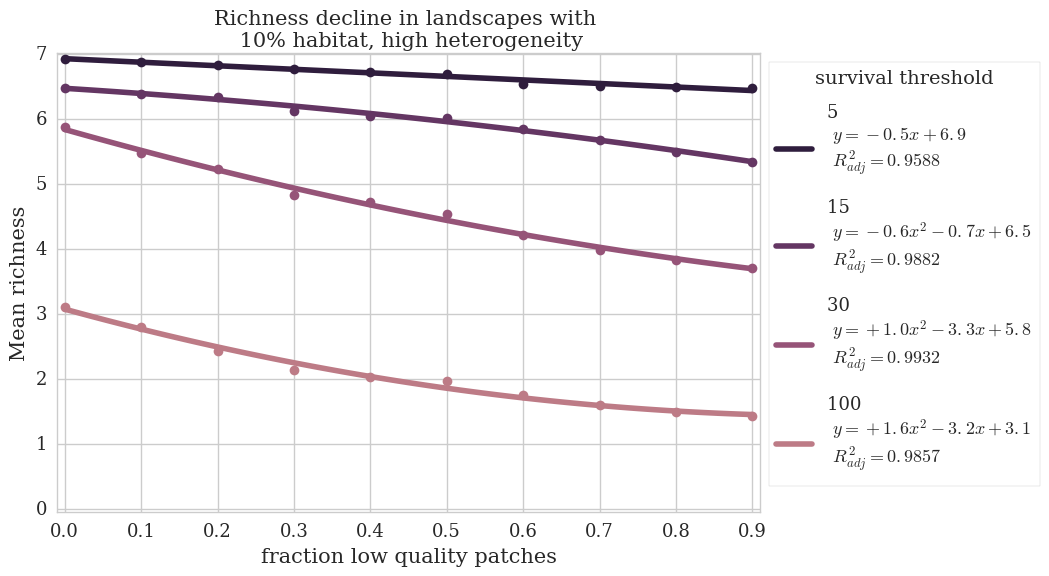

In [82]:
fig4c()

In [91]:
def fig4b():
    datos = np.zeros((2, 100, 10, 6, 10, 10, 10)) # het, comunidad, intensificación, tiempo, x, y, especies 
    res = [None] * 2
    p = [None] * 2
    r2_adj = [None] * 2
    label = [None] * 2
    het = 2
    
    riqueza_total = np.zeros((2, 100, 10)) # threshold, comunidad, intensificación
    riqueza_total_mean = np.zeros((2, 10)) # threshold, intensificación

    for i, habitat in enumerate(['2b', '1b']):
        
        datos[i] = leer_datos(str(het), habitat)[0]
     
        for comunidad in range(len(datos[i])):
            for intensificacion in range(len(datos[i, comunidad])):
                riqueza_total[i, comunidad, intensificacion] = riqueza_paisaje(
                                                                datos[i, comunidad, intensificacion, ...],
                                                                t=-1, biomasa_min = 80)[1]
        
        riqueza_total_mean[i] = calcular_promedio(riqueza_total[i, con_cambios, :])[0]
        
        
        res[i], p[i], r2_adj[i] = ajustar_polinomio(riqueza_total_mean[i], 2)
        label[i] = '$y = {:+.1f} x^2 {:+.1f} x {:+.1f}$ \n $R^2_{{adj}}={:.4f}$ '.format(
                 float(p[i][2]), float(p[i][1]), float(p[i][0]), float(r2_adj[i]))
        
        if ajustar_polinomio(riqueza_total_mean[i], 1)[2] > r2_adj[i]:
            res[i], p[i], r2_adj[i] = ajustar_polinomio(riqueza_total_mean[i], 1)
            
            label[i] = '$y = {:+.1f} x {:+.1f}$ \n $R^2_{{adj}}={:.4f}$ '.format(
                 float(p[i][1]), float(p[i][0]), float(r2_adj[i]))   
    
    x = np.linspace(0, .9, 100)
    xdata = np.array(range(10)) / 10
    xlabels = np.array(range(10)) / 10 

    colores = ['DarkRed', 'IndianRed']
    
    fig = plt.figure()
    
    for i, habitat in enumerate(['30%', '10%']):           
        plt.plot(x, p[i](x), lw = 4, color= colores[i], label='{} \n {}'.format(habitat, label[i])) #fit
        plt.plot(xdata, riqueza_total_mean[i], 'o', color= colores[i]) #data points

    plt.ylim(-0.05, 7.01)
    plt.xlim(-0.01, 0.91)
    plt.xticks(xdata, xlabels)
    plt.xlabel("fraction low quality patches")
    plt.ylabel('Mean richness')
    plt.title("Richness decline in landscapes with \n high heterogeneity, survival threshold = 80")
    plt.legend(loc='upper left', title="habitat", bbox_to_anchor=(1, 1), frameon=1, labelspacing=1.5)
    plt.tight_layout()
    plt.show()

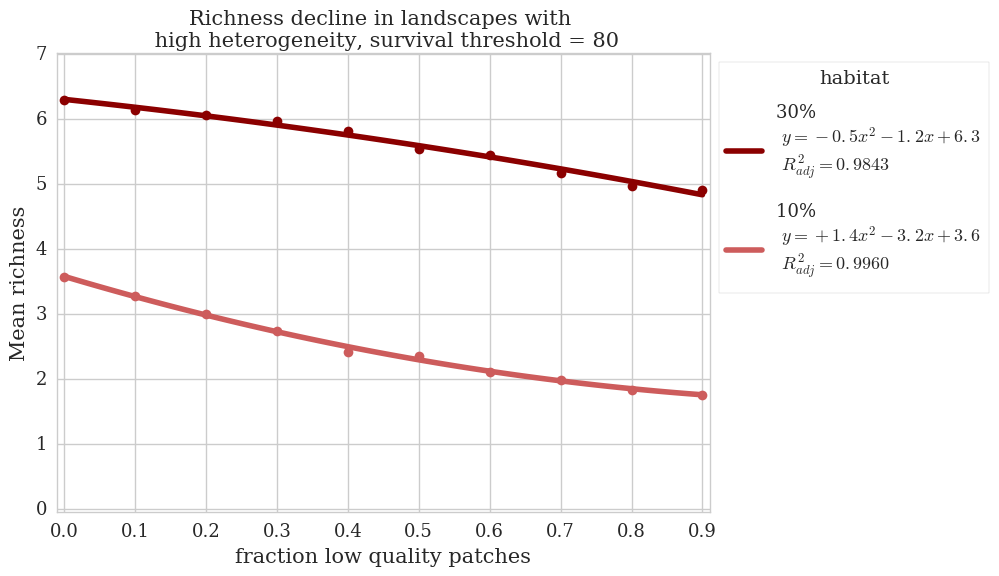

In [94]:
fig4b()

In [99]:
def fig4a():
    res = [None] * 5
    p = [None] * 5
    r2_adj = [None] * 5
    label = [None] * 5
    
    for het in [0, 1, 4]:
        res[het], p[het], r2_adj[het] = ajustar_polinomio(riqueza_total_mean[het], 2)
        label[het] = '$y = {:+.1f} x^2 {:+.1f} x {:+.1f}$ \n $R^2_{{adj}}={:.4f}$ '.format(
                 float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2_adj[het]))
        
        if ajustar_polinomio(riqueza_total_mean[het], 1)[2] > r2_adj[het]:
            res[het], p[het], r2_adj[het] = ajustar_polinomio(riqueza_total_mean[het], 1)
            
            label[het] = '$y = {:+.1f} x {:+.1f}$ \n $R^2_{{adj}}={:.4f}$ '.format(
                 float(p[het][1]), float(p[het][0]), float(r2_adj[het]))
    
    x = np.linspace(0, .9, 100)
    xdata = np.array(range(10)) / 10
    xlabels = np.array(range(10)) / 10 

    colores = ['#E6852B', '#23B823', '#9BA7F5','#697CF5','#2F3E9D']
    
    fig = plt.figure()

    for het in [0, 1, 4]:
        plt.plot(x, p[het](x), lw = 4, color= colores[het], 
                 label='{} \n {}'.format(het, label[het])) #fit
        plt.plot(xdata, riqueza_total_mean[het], 'o', color= colores[het]) #data points
        
    plt.ylim(-0.05, 7.01)
    plt.xlim(-0.01, .91)
    plt.xticks(xdata, xlabels)
    plt.xlabel("fraction of low quality patches")
    plt.ylabel('Mean richness')
    plt.title('Richness decline in 10%-habitat landscapes')
    plt.legend(loc='upper left', title="heterogeneity", bbox_to_anchor=(1, 1), frameon=1)
    plt.tight_layout()

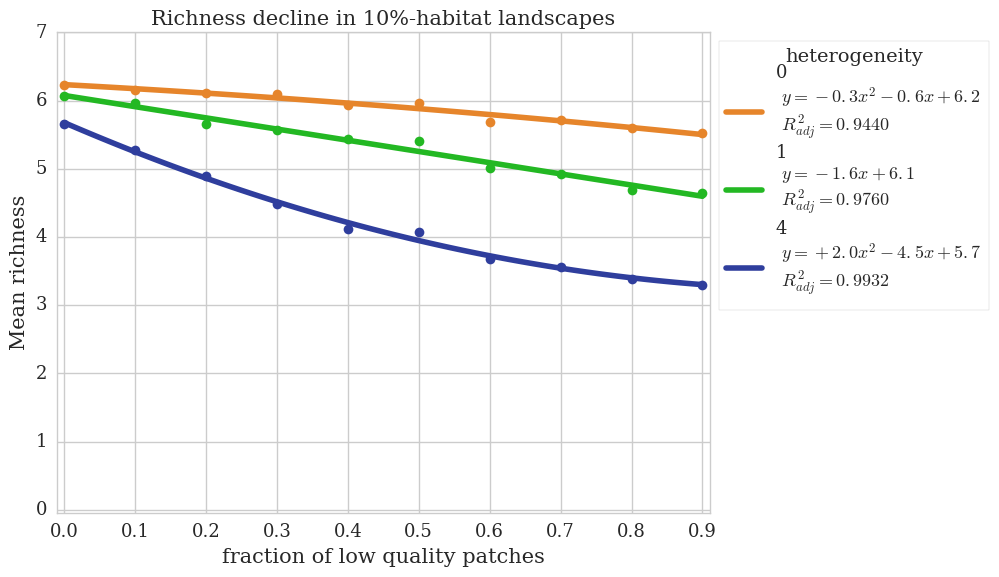

In [100]:
fig4a()

In [60]:
np.savetxt('means_10.txt', riqueza_total_mean, '%.4f', delimiter=',', newline='\r\n')